# Fase de exploraci√≥n y an√°lisis de los datos
El conjunto de datos sobre el que se articula el estudio planteado proviene de la competici√≥n [IberLEF 2023 Task PoliticEs. Political ideology detection in Spanish texts](https://codalab.lisn.upsaclay.fr/competitions/10173). Este dataset es una extensi√≥n de PoliCorpus 2020 dataset (Garc√≠a-D√≠az et al. 2022a) y el empleado para la edici√≥n anterior de este mismo concurso IberLEF 2022 Task PoliticEs. Spanish Author Profiling for Political Ideology. El dataset se compone de una recopilaci√≥n de tweets publicados entre 2020 y 2022 por cuentas de twitter pertenecientes a pol√≠ticos, periodistas y diferentes celebridades Espa√±olas empleando la herramienta UMUCorpusClasifier.

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("../data/politicES_phase_1_traindev_public.csv")
df.head()

label gender  profession ideology_binary  \
0  00369358fac3b8d42845f82f0c3ececc   male  journalist            left   
1  00369358fac3b8d42845f82f0c3ececc   male  journalist            left   
2  00369358fac3b8d42845f82f0c3ececc   male  journalist            left   
3  00369358fac3b8d42845f82f0c3ececc   male  journalist            left   
4  00369358fac3b8d42845f82f0c3ececc   male  journalist            left   

  ideology_multiclass                                              tweet  
0                left  @user Escribi√≥ un libro result√≥n, con gracejo,...  
1                left       @user Lo prometido es deuda. Aqu√≠ la foto: .  
2                left  @user Bastante √±o√±a. Me jart√© a llorar. De lo ...  
3                left  @user No s√© nada acerca de eso, pero est√° clar...  
4                left  @user ¬øEn qu√© medio tienen su podcast esos, di...

El conjunto de datos est√° correctamente etiquetado, con las etiquetas binaria y multiclase. El principal objetivo del tratamiento de los datos ser√° el de realizar predicciones sobre una de estas dos variables, por lo que el resto de ellas son prescindibles. Antes de proceder a eliminarlas, se elaborar√°n algunos gr√°ficos informativos para entender mejor los datos con los que se trabaja.

## An√°lisis exploratorio

### Variables categ√≥ricas

En primer lugar, se realiza un an√°lisis detallado de la distribuci√≥n de las diferentes variables contenidas en el conjunto de datos


In [5]:
# df = df.drop(["label"], axis = 1)
dist = pd.DataFrame({})
for column in ["gender", "profession", "ideology_binary", "ideology_multiclass"]:
    for value in df[column].unique():
        count = np.sum(df[column] == value)
        entry = pd.DataFrame({
            "column": column,
            "value": value,
            "count": count,
            "%": count / df[column].count() 
        }, index= [0])
        dist = pd.concat([dist, entry]).reset_index(drop=True)  
dist

column           value  count         %
0                gender            male   9800  0.680556
1                gender          female   4600  0.319444
2            profession      journalist   8640  0.600000
3            profession       celebrity    960  0.066667
4            profession      politician   4800  0.333333
5       ideology_binary            left   8000  0.555556
6       ideology_binary           right   6400  0.444444
7   ideology_multiclass            left   2760  0.191667
8   ideology_multiclass           right   1680  0.116667
9   ideology_multiclass  moderate_right   4720  0.327778
10  ideology_multiclass   moderate_left   5240  0.363889

Del an√°lisis general de la distribuci√≥n de las diferentes variables, es posible sacar algunas conclusiones:
- Existe un sesgo de g√©nero altamente notable en el conjunto de datos: El __68% de los tweets__ pertenecen a autores de __g√©nero masculino__. 
- El 60% de los tweets pertenecen a __periodistas__. 
- El balance entre las ideolog√≠as se inclina ligeramente hacia la izquierda: El 55% de los tweets recogidos en el dataset han sido etiquetados como pertenecientes a la izquierda.
- La variable de ideolog√≠a multiclase se distribuye de manera que las ideolog√≠as moderadas componen el grosso del conjunto, mientras que las categor√≠as extremistas (etiquetadas como "left" y "right") abarcan el 30% de los tweets. 

### Variable principal `tweet`

Para proceder con el an√°lisis de la variable principal del dataset, la que contiene los tweets que se pretenden procesar, se proceder√° en primer lugar analizando las caracter√≠sticas ling√º√≠sticas de los textos para las diferentes categor√≠as que permiten diferenciar las diferentes variables.

> Es necesario para el an√°lisis de las caracter√≠sticas ling√º√≠sticas de la variable tweet realizar algunas acciones previas de preprocesamiento como la tokenizaci√≥n y la lematizaci√≥n.

En primer lugar, se proceder√° a eliminar los saltos de l√≠nea, dobles espacios, tabulaciones y otros caracteres indeseados para esta fase. 

In [6]:
import re
def replace_characters(t):
    s = t.replace('\r\n', ' ')
    s = s.replace('\n\n', ' ')
    s = s.replace('\n', ' ')
    s = s.replace('\r', ' ')
    return re.sub('\s\s+', ' ', s)
df["tweet_clean"] = df["tweet"].apply(replace_characters)

In [7]:
import spacy
nlp = spacy.load("es_core_news_md")
def clear_stopwords(tweet):
    return " ".join([token.text.lower() for token in nlp(tweet) 
                     if not token.is_stop
                     and not token.is_punct
                     and not token.text.lower() in ["@user","political_party", "politician", "hashtag", "user"]
                    ])
df["tweet_clean"] = df["tweet"].apply(clear_stopwords)

#### Tweets por g√©nero

##### Masculino

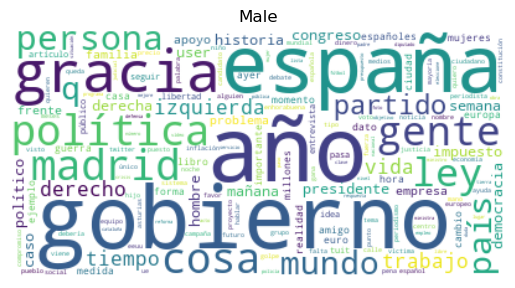

In [47]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import textstat
import functools
textstat.set_lang('es')

stats = [textstat.fernandez_huerta,textstat.szigriszt_pazos, textstat.gutierrez_polini, textstat.crawford, textstat.reading_time]
stats_name = ["Fernandez Huerta", "Szigriszt Pazos", "Gutierrez Polini", "Crawford", "Tiempo de lectura"]
df_stats_tweets = pd.DataFrame({})

def show_word_cloud(words, title):
    wordcloud = WordCloud(background_color='white').generate(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

male = " ".join(df[df["gender"] == "male"]["tweet_clean"])
show_word_cloud(male, "Male")

In [9]:
from collections import Counter
Counter(male.split()).most_common(10)

[('gobierno', 668),
 ('espa√±a', 564),
 ('a√±os', 477),
 ('üëá', 464),
 ('gracias', 382),
 ('ley', 332),
 ('madrid', 289),
 ('gente', 259),
 ('pa√≠s', 243),
 ('a√±o', 238)]

In [63]:
male_tweets = df[df["gender"] == "male"]["tweet"]
male_stats = {"Group": "Male"}
for func, name in zip(stats, stats_name):
    male_stats[name] = np.sum(male_tweets.apply(lambda x: func(x)) / len(male_tweets))
df_stats_tweets = pd.concat([pd.DataFrame(male_stats, index=[0]), df_stats_tweets]).reset_index(drop=True)
df_stats_tweets

Group  Fernandez Huerta  Szigriszt Pazos  Gutierrez Polini  Crawford  \
0    Male         78.210451        74.330711         43.963551  4.138418   
1    Male         78.210451        74.330711         43.963551  4.138418   
2  Female         78.203335        74.287509         43.927387  4.125435   

   Tiempo de lectura  
0           2.061668  
1           2.061668  
2           2.076802

##### Femenino

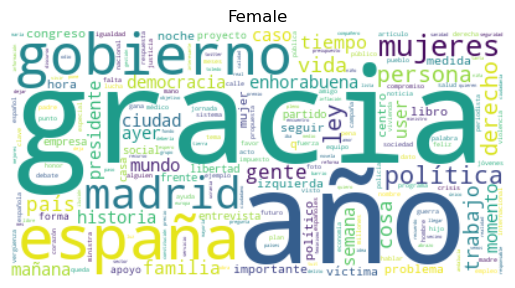

In [25]:
female = " ".join(df[df["gender"] == "female"]["tweet_clean"])
show_word_cloud(female, "Female")

In [15]:
female = " ".join(df[df["gender"] == "female"]["tweet_clean"])
Counter(female.split()).most_common(10)

[('gracias', 383),
 ('Ô∏è', 284),
 ('a√±os', 234),
 ('espa√±a', 233),
 ('gobierno', 216),
 ('madrid', 197),
 ('mujeres', 161),
 ('ley', 151),
 ('üëá', 138),
 ('vida', 131)]

In [61]:
female_tweets = df[df["gender"] == "female"]["tweet"]
female_stats = {"Group": "Female"}
for func, name in zip(stats, stats_name):
    female_stats[name] = np.sum(female_tweets.apply(lambda x: func(x)) / len(female_tweets))
df_stats_tweets = pd.concat([pd.DataFrame(female_stats, index=[0]), df_stats_tweets]).reset_index(drop=True)
df_stats_tweets

#### Tweets por profesi√≥n

##### Periodistas

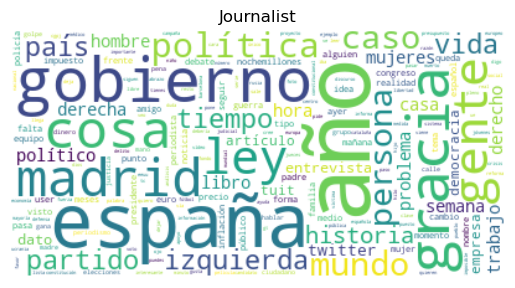

In [29]:
journalist = " ".join(df[df["profession"] == "journalist"]["tweet_clean"])
show_word_cloud(journalist, "Journalist")

In [30]:
Counter(journalist.split()).most_common(10)

[('a√±os', 428),
 ('espa√±a', 374),
 ('gobierno', 363),
 ('gracias', 317),
 ('üëá', 292),
 ('madrid', 276),
 ('ley', 273),
 ('gente', 217),
 ('a√±o', 207),
 ('mundo', 181)]

In [65]:
journalist_tweets = df[df["profession"] == "journalist"]["tweet"]
journalist_stats = {"Group": "Journalist"}
for func, name in zip(stats, stats_name):
    journalist_stats[name] = np.sum(journalist_tweets.apply(lambda x: func(x)) / len(journalist_tweets))
df_stats_tweets = pd.concat([pd.DataFrame(journalist_stats, index=[0]), df_stats_tweets]).reset_index(drop=True)
df_stats_tweets

Group  Fernandez Huerta  Szigriszt Pazos  Gutierrez Polini  Crawford  \
0  Journalist         79.915144        76.092235         44.653862  3.988229   
1      Female          0.000000         0.000000          0.000000  0.000000   
2        Male         78.210451        74.330711         43.963551  4.138418   
3        Male         78.210451        74.330711         43.963551  4.138418   
4      Female         78.203335        74.287509         43.927387  4.125435   

   Tiempo de lectura  
0           1.924310  
1           0.000000  
2           2.061668  
3           2.061668  
4           2.076802

##### Celebridades

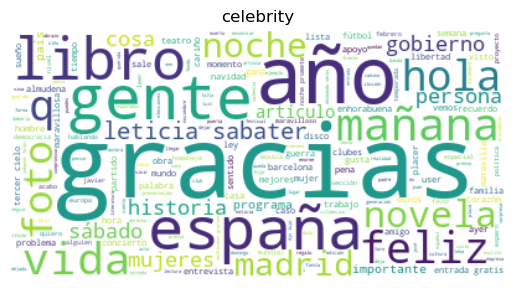

In [35]:
celebrity = " ".join(df[df["profession"] == "celebrity"]["tweet_clean"])
show_word_cloud(celebrity, "celebrity")

In [36]:
Counter(celebrity.split()).most_common(10)

[('Ô∏è', 127),
 ('gracias', 107),
 ('‚úå', 82),
 ('üèº', 68),
 ('üëá', 42),
 ('noche', 42),
 ('üôè', 41),
 ('‚ù§', 41),
 ('a√±os', 37),
 ('espa√±a', 31)]

In [68]:
celebrity_tweets = df[df["profession"] == "celebrity"]["tweet"]
celebrity_stats = {"Group": "Celebrity"}
for func, name in zip(stats, stats_name):
    celebrity_stats[name] = np.sum(celebrity_tweets.apply(lambda x: func(x)) / len(celebrity_tweets))
df_stats_tweets = pd.concat([pd.DataFrame(celebrity_stats, index=[0]), df_stats_tweets]).reset_index(drop=True)
df_stats_tweets

Group  Fernandez Huerta  Szigriszt Pazos  Gutierrez Polini  Crawford  \
0   Celebrity         82.784437        78.931344         45.665729  3.727812   
1   celebrity         82.784437        78.931344         45.665729  3.727812   
2  Journalist         82.784437        78.931344         45.665729  3.727812   
3  Journalist         79.915144        76.092235         44.653862  3.988229   
4      Female          0.000000         0.000000          0.000000  0.000000   
5        Male         78.210451        74.330711         43.963551  4.138418   
6        Male         78.210451        74.330711         43.963551  4.138418   
7      Female         78.203335        74.287509         43.927387  4.125435   

   Tiempo de lectura  
0           1.761594  
1           1.761594  
2           1.761594  
3           1.924310  
4           0.000000  
5           2.061668  
6           2.061668  
7           2.076802

##### Pol√≠ticos

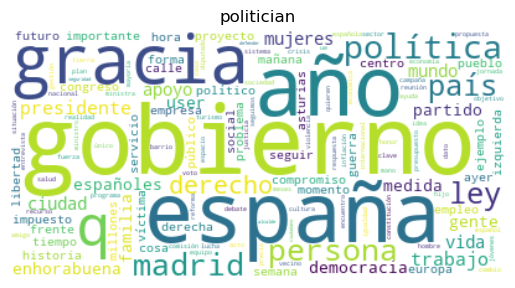

In [42]:
politician = " ".join(df[df["profession"] == "politician"]["tweet_clean"])
show_word_cloud(politician, "politician")

In [43]:
Counter(politician.split()).most_common(10)

[('gobierno', 503),
 ('espa√±a', 392),
 ('gracias', 341),
 ('üëá', 268),
 ('a√±os', 246),
 ('Ô∏è', 237),
 ('q', 230),
 ('ley', 199),
 ('madrid', 189),
 ('pa√≠s', 171)]

In [69]:
politician_tweets = df[df["profession"] == "politician"]["tweet"]
politician_stats = {"Group": "Politician"}
for func, name in zip(stats, stats_name):
    politician_stats[name] = np.sum(politician_tweets.apply(lambda x: func(x)) / len(politician_tweets))
df_stats_tweets = pd.concat([pd.DataFrame(politician_stats, index=[0]), df_stats_tweets]).reset_index(drop=True)
df_stats_tweets

Group  Fernandez Huerta  Szigriszt Pazos  Gutierrez Polini  Crawford  \
0  Politician         74.220387        70.198440         42.345898  4.478438   
1   Celebrity         82.784437        78.931344         45.665729  3.727812   
2   celebrity         82.784437        78.931344         45.665729  3.727812   
3  Journalist         82.784437        78.931344         45.665729  3.727812   
4  Journalist         79.915144        76.092235         44.653862  3.988229   
5      Female          0.000000         0.000000          0.000000  0.000000   
6        Male         78.210451        74.330711         43.963551  4.138418   
7        Male         78.210451        74.330711         43.963551  4.138418   
8      Female         78.203335        74.287509         43.927387  4.125435   

   Tiempo de lectura  
0           2.383431  
1           1.761594  
2           1.761594  
3           1.761594  
4           1.924310  
5           0.000000  
6           2.061668  
7           2.061668  
8           2.076802

### Tweets por ideolog√≠a

##### Izquierda moderada

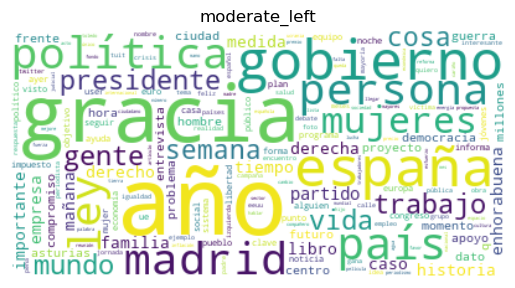

In [41]:
moderate_left = " ".join(df[df["ideology_multiclass"] == "moderate_left"]["tweet_clean"])
show_word_cloud(moderate_left, "moderate_left")

In [45]:
Counter(moderate_left.split()).most_common(10)

[('gracias', 312),
 ('a√±os', 289),
 ('espa√±a', 270),
 ('gobierno', 270),
 ('üëá', 243),
 ('Ô∏è', 214),
 ('ley', 173),
 ('pa√≠s', 162),
 ('a√±o', 155),
 ('madrid', 154)]

##### Derecha moderada

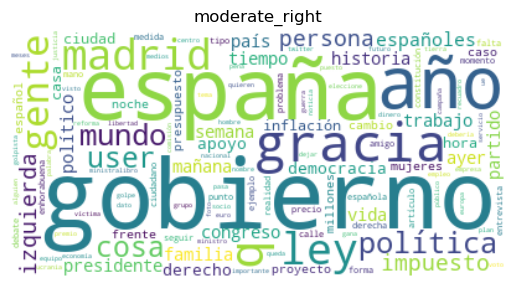

In [46]:
moderate_right = " ".join(df[df["ideology_multiclass"] == "moderate_right"]["tweet_clean"])
show_word_cloud(moderate_right, "moderate_right")

In [47]:
Counter(moderate_right.split()).most_common(10)

[('gobierno', 419),
 ('espa√±a', 331),
 ('gracias', 244),
 ('a√±os', 214),
 ('q', 191),
 ('ley', 187),
 ('madrid', 179),
 ('üëá', 155),
 ('Ô∏è', 151),
 ('gente', 122)]

##### Extrema izquierda

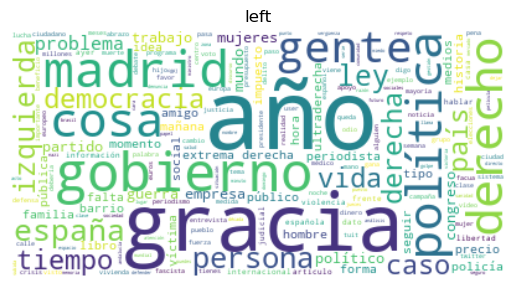

In [48]:
left = " ".join(df[df["ideology_multiclass"] == "left"]["tweet_clean"])
show_word_cloud(left, "left")

In [49]:
Counter(left.split()).most_common(10)

[('üëá', 183),
 ('a√±os', 138),
 ('gracias', 128),
 ('gobierno', 119),
 ('madrid', 111),
 ('derecha', 99),
 ('gente', 80),
 ('espa√±a', 80),
 ('üèª', 79),
 ('ley', 78)]

##### Extrema derecha

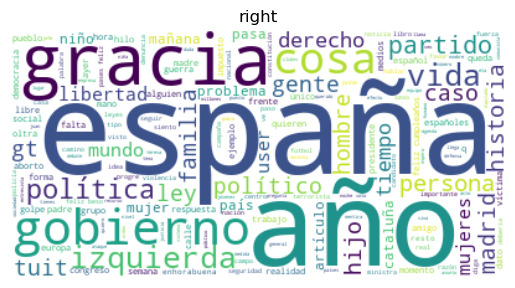

In [50]:
right = " ".join(df[df["ideology_multiclass"] == "right"]["tweet_clean"])
show_word_cloud(right, "right")

In [51]:
Counter(right.split()).most_common(10)

[('espa√±a', 116),
 ('gracias', 81),
 ('üëè', 78),
 ('gobierno', 76),
 ('a√±os', 70),
 ('feliz', 67),
 ('Ô∏è', 57),
 ('ley', 45),
 ('vida', 45),
 ('madrid', 42)]

## Preprocesado

Preprocesado para la clasificaci√≥n multietiqueta:


In [7]:
from sklearn.preprocessing import LabelEncoder
df_test = pd.read_csv("../data/development_test.csv")
df_clean_multilabel_test = pd.DataFrame({})
df_clean_multilabel = pd.DataFrame({})
df_clean_multilabel["tweet"] = df["tweet"]
df_clean_multilabel_test["tweet"] = df_test["tweet"]
for label in ["gender", "profession", "ideology_binary", "ideology_multiclass"]:
    enc = LabelEncoder()
    df_clean_multilabel[label] = enc.fit_transform(df[label])
    df_clean_multilabel_test[label] = enc.transform(df_test[label])
df_clean_multilabel.to_csv("../data/multilabel_encoded.csv")
df_clean_multilabel_test.to_csv("../data/multilabel_encoded_test.csv")

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_clean_multilabel = pd.DataFrame({})
df_clean_multilabel["tweet"] = df["tweet"]
for label in ["gender", "profession", "ideology_binary", "ideology_multiclass"]:
    enc = LabelEncoder()
    df_clean_multilabel[label] = enc.fit_transform(df[label])

In [13]:
df_procesed.to_csv("../data/procesed.csv")

In [7]:
df_test = pd.read_csv("../data/development_test.csv")
df_test_processed = pd.DataFrame({})
df_test_processed["tweets"] = df_test["tweet"]
df_test_processed["labels"] = df_test["ideology_multiclass"].map({'moderate_left': 0, 'moderate_right': 1, "left": 2, "right": 3})
df_test_processed.to_csv("../data/procesed_test.csv")

## Tokenizaci√≥n para transformers


In [6]:
from transformers import BertTokenizer, RobertaTokenizer
from sklearn.model_selection import train_test_split

tokenizer_bert = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
tokenizer_roberta = RobertaTokenizer.from_pretrained("xlm-roberta-base")

def tokenize_roberta_tweet(tweet):
    input_ids = tokenizer_roberta.encode(tweet)
    input_ids = [4] + input_ids + [5]
    attention_mask = [1] * len(input_ids) + [0] * (512 - len(input_ids))
    return input_ids + [0] * (512 - len(input_ids))

def tokenize_bert_tweet(tweet):
    input_ids = tokenizer_bert.encode(tweet)
    return input_ids + [0] * (512 - len(input_ids))

def input_type_ids_roberta(row):
    return [1] * len(row["roberta_ids"]) + [0] * (512 - len(row["roberta_ids"]))

def input_type_ids_bert(row):
    return [1] * len(row["bert_ids"]) + [0] * (512 - len(row["bert_ids"]))

def prepare_datasets():
    df = pd.read_csv("../data/multilabel_encoded.csv", index_col=0)
    df_test = pd.read_csv("../data/multilabel_encoded_test.csv", index_col=0)
    df["roberta_ids"] = df["tweet"].apply(tokenize_roberta_tweet)
    df["bert_ids"] = df["tweet"].apply(tokenize_bert_tweet)
    df["roberta_token_type_ids"] = [[0] * 512] * len(df)
    df["bert_token_type_ids"] = [[0] * 512] * len(df)
    df["roberta_attention_masks"] = df.apply(input_type_ids_roberta, axis=1)
    df["bert_attention_masks"] = df.apply(input_type_ids_gpt2, axis=1)
    df_train, df_val, y_train, y_val = train_test_split(
        df[['roberta_ids', 'gpt2_ids', 'roberta_token_type_ids', 'roberta_attention_masks', 'gpt2_attention_masks', 'gpt2_token_type_ids']],
        df[['gender', 'profession','ideology_binary', 'ideology_multiclass']],
        test_size=0.15,
        random_state = 100
    )
    df_train['gender'] = y_train['gender']
    df_train['profession'] = y_train['profession']
    df_train['ideology_binary'] = y_train['ideology_binary']
    df_train['ideology_multiclass'] = y_train['ideology_multiclass']
    df_val['gender'] = y_val['gender']
    df_val['profession'] = y_val['profession']
    df_val['ideology_binary'] = y_val['ideology_binary']
    df_val['ideology_multiclass'] = y_val['ideology_multiclass']
    df_train.to_pickle("./train_bert.pickle")
    df_val.to_pickle("./validation_bert.pickle")
    df_test["roberta_ids"] = df_test["tweet"].apply(tokenize_roberta_tweet)
    df_test["bert_ids"] = df_test["tweet"].apply(tokenize_gpt_tweet)
    df_test["roberta_token_type_ids"] = [[0] * 512] * len(df_test)
    df_test["bert_token_type_ids"] = [[0] * 512] * len(df_test)
    df_test["roberta_attention_masks"] = df_test.apply(input_type_ids_roberta, axis=1)
    df_test["bert_attention_masks"] = df_test.apply(input_type_ids_gpt2, axis=1)
    df_test.drop('tweet', axis=1)
    df_test.to_pickle("./test_bert.pickle")
prepare_datasets()

OSError: Can't load tokenizer for 'xlm-roberta-base'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'xlm-roberta-base' is the correct path to a directory containing all relevant files for a RobertaTokenizer tokenizer.

### Dataset para el test

In [76]:
df_test = pd.read_csv("../data/multilabel_encoded.csv", index_col=0)
df_test["ideology_multiclass"]

array([0, 3, 2, 1], dtype=int64)